# 気象庁のデータをグラフで比較

## 気象データの取り込み

[気象庁の過去データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)から、気象データをダウンロードし、csvファイルはGoogle Colabの左側から手動でアップロードする。

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib 
import matplotlib.dates as mdates
import datetime

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


下記
- index_col = 0 で、年月日をインデックスに設定
- header = 2で、カラム名を取得できるので設定している。
- usecols で使用するカラムをカラム名で絞り込んでいる。別のデータも使用するなら適宜修正する。   

In [ ]:
df = pd.read_csv('utf8_2008_2013.csv', header=2, index_col=0, parse_dates=True, usecols=['年月日','日照時間(時間)','平均気温(℃)', '降水量の合計(mm)','合計全天日射量(MJ/㎡)','平均雲量(10分比)'])

In [ ]:
df_tmp = pd.read_csv('utf8_2014_2019.csv', header=2, index_col=0, parse_dates=True, usecols=['年月日','日照時間(時間)','平均気温(℃)', '降水量の合計(mm)','合計全天日射量(MJ/㎡)','平均雲量(10分比)'])

# データをdfにひとまとめにする
df = df.append(df_tmp)

In [ ]:
df_tmp = pd.read_csv('utf8_2020_07_24.csv', header=2, index_col=0, parse_dates=True, usecols=['年月日','日照時間(時間)','平均気温(℃)', '降水量の合計(mm)','合計全天日射量(MJ/㎡)','平均雲量(10分比)'])

# データをdfにひとまとめにする
df = df.append(df_tmp)

日照時間と降水量を年ごとに並べ替える

In [ ]:
# 月ごと集計データに並べ替え
df_sum = df.resample('M').sum()

df_sun = pd.DataFrame(index=[])
df_rain = pd.DataFrame(index=[])

for year in range(2008, 2021):
  df_sun = pd.concat([df_sum.loc[str(year):str(year)+'-07', ['日照時間(時間)']].rename(columns={'日照時間(時間)': str(year)}).reset_index().drop("年月日", axis=1), df_sun], axis=1)
  df_rain = pd.concat([df_sum.loc[str(year):str(year)+'-07', ['降水量の合計(mm)']].rename(columns={'降水量の合計(mm)': str(year)}).reset_index().drop("年月日", axis=1), df_rain], axis=1)



## グラフの描画

 **matplot**

引数
alpha : 透過度

In [ ]:
# 累積和グラフを表示
# df : dataFrame
# ax : Axes
# key : グラフ表示の対象とするカラム
# years : 対象年 [2020, 2019, 2018, 2017]
# start: グラフ表示開始日 '0401'
# end : グラフ表示終了日 '0723'
def cumulative_sum_graph(df, ax, key, years, start, end):

  for year in years:
    ax.plot(df.loc['2019'+start:'2019'+end].index, df.loc[str(year)+start:str(year)+end, [key]].cumsum(),  label=str(year)+'年', alpha=0.6)
  
  plt.axvline(x=datetime.date(2019, 6, 10), ymin=0.0, ymax=1.0, color='red', alpha=0.6)
  plt.text(x=datetime.date(2019, 6, 10), y=0.5, s=' 6/10 巨峰満開', color='red', fontsize=18)

  ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d")) # x軸の目盛りを月日のみ表示

  plt.title(key + ': 累積和', fontsize=24) # タイトル設定
  plt.tick_params(labelsize=18)
  plt.legend(fontsize=18)

In [ ]:
# 年次月ごとの比較グラフを表示
# df: dataFrame
# ax : Axes
# key : グラフタイトル
# years : 対象年 [2020, 2019, 2018, 2017]
# width: 棒グラフの幅
def monthly_comparison_graph(df, ax, key, years, width):

  for i, year in enumerate(years):
    ax.bar(df.index - width/2 * i + 0.15, df[str(year)], width / 2, label=str(year)+ '年', tick_label=['1月', '2月', '3月', '4月', '5月', '6月', '7月'])

  plt.title(key + ' : 月別比較', fontsize=24) # タイトル設定
  plt.tick_params(labelsize=18)
  plt.legend(fontsize=18)

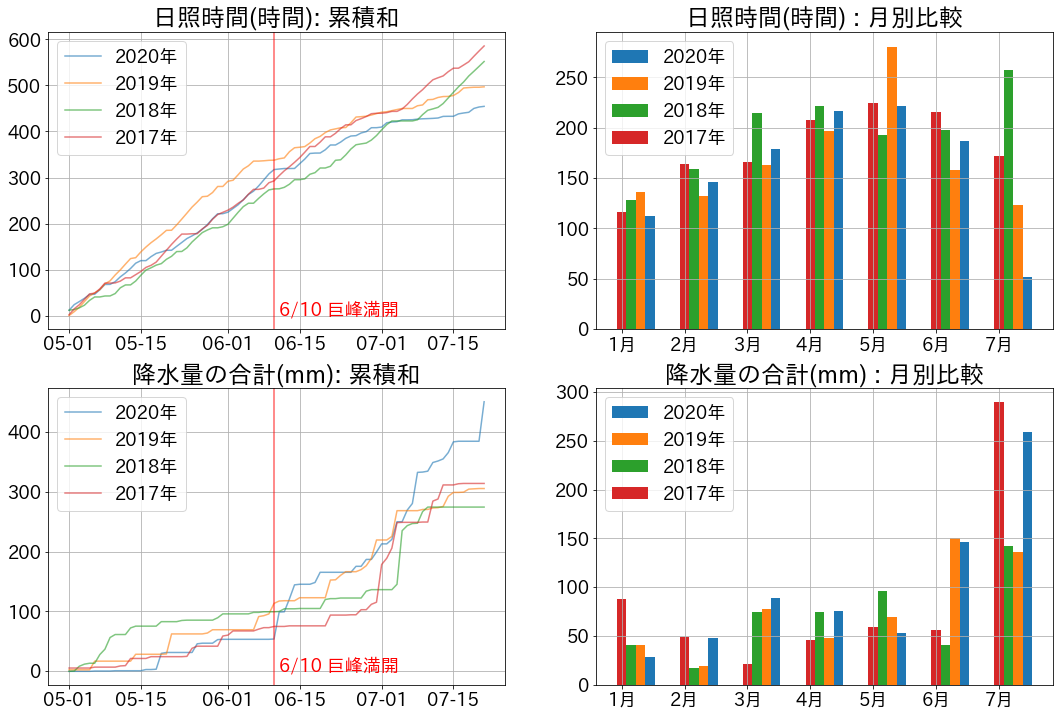

In [ ]:
fig = plt.figure(figsize=(18, 12), facecolor='white') # figsizeでグラフ全体のサイズ指定

# 出力したいカラムを設定しておく。for分の中で使用するため。
dic = {'日照時間(時間)': 1,'降水量の合計(mm)': 3}

for key, value in dic.items():
    ax = fig.add_subplot(2,2,value) # 2,2,1 で 2x2の1番目にグラフを描画、という意味。
    ax.grid() # グリッド（罫線）を表示

    # 累積和のグラフ表示
    cumulative_sum_graph(df, ax, key, [2020, 2019, 2018, 2017], '0501', '0721')

# 出力したいカラムを設定しておく。for分の中で使用するため。
dic = {'日照時間(時間)': 2, '降水量の合計(mm)': 4}
data_dic  ={'日照時間(時間)': df_sun, '降水量の合計(mm)': df_rain}

for key, value in dic.items():

  ax = fig.add_subplot(2,2,value) # 2,2,1 で 2x2の1番目にグラフを描画、という意味。
  ax.grid() # グリッド（罫線）を表示

  monthly_comparison_graph(data_dic[key], ax, key, [2020, 2019, 2018, 2017], 0.3)

plt.show()

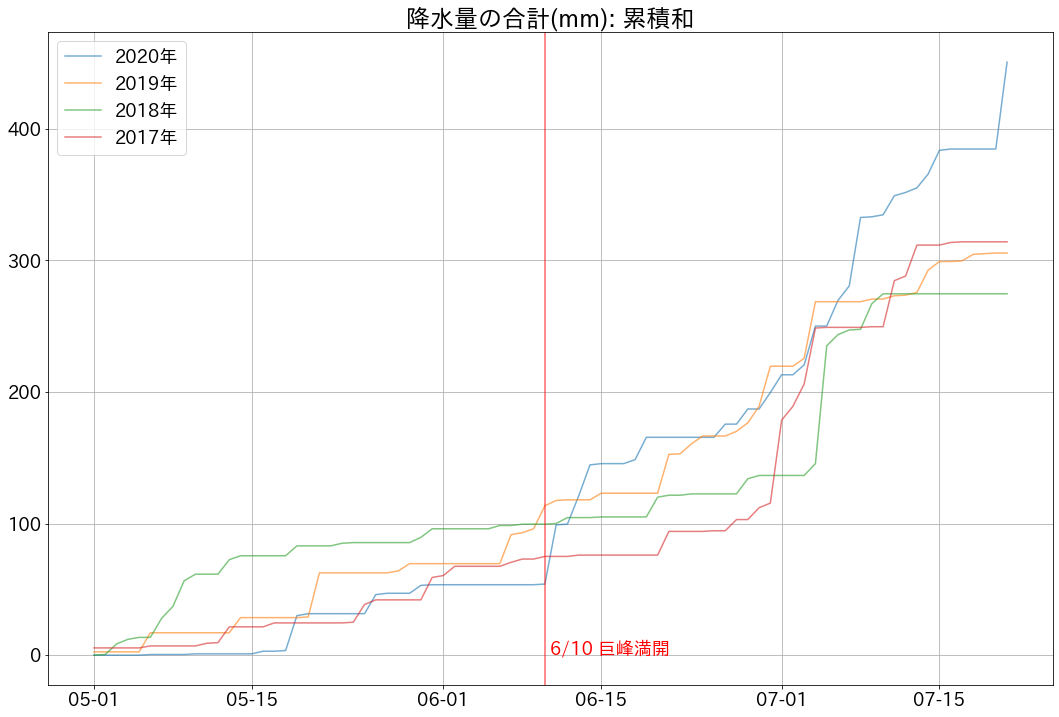

In [ ]:
fig = plt.figure(figsize=(18, 12), facecolor='white') # figsizeでグラフ全体のサイズ指定

ax = fig.add_subplot(1, 1, 1) # 2,2,1 で 2x2の1番目にグラフを描画、という意味。
ax.grid() # グリッド（罫線）を表示

# 累積和のグラフ表示
#cumulative_sum_graph(df, ax, '日照時間(時間)', [2020, 2019, 2018, 2017],'0501', '0724')
cumulative_sum_graph(df, ax, '降水量の合計(mm)', [2020, 2019, 2018, 2017], '0501', '0721')

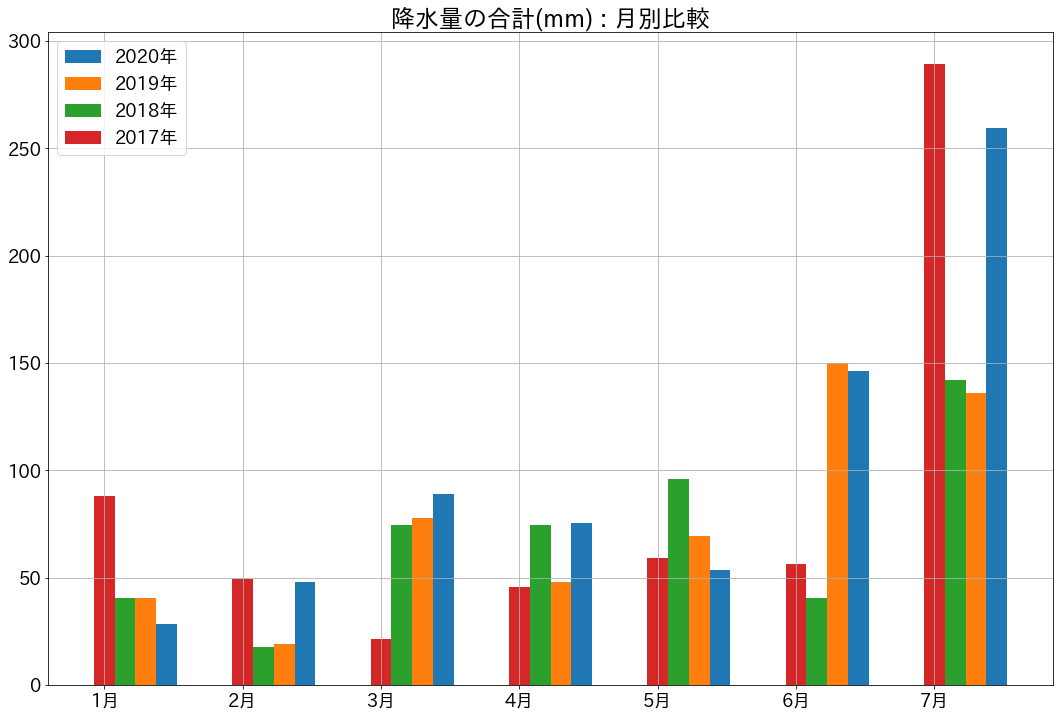

In [ ]:
fig = plt.figure(figsize=(18, 12), facecolor='white') # figsizeでグラフ全体のサイズ指定

ax = fig.add_subplot(1, 1, 1) # 2,2,1 で 2x2の1番目にグラフを描画、という意味。
ax.grid() # グリッド（罫線）を表示

#monthly_comparison_graph(df_sun, ax, '日照時間(時間)', [2020, 2019, 2018, 2017], 0.3)
monthly_comparison_graph(df_rain, ax, '降水量の合計(mm)', [2020, 2019, 2018, 2017], 0.3)